# Cancer Dataset Visualization

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
cancer = pd.read_csv('/Users/kryptonempyrean/Desktop/archive (1)/cancer.csv')
cancer.head()

,Id,Diagnosis,Radius (mean),Texture (mean),Perimeter (mean),Area (mean),Smoothness (mean),Compactness (mean),Concavity (mean),Concave points (mean),...,Radius (worst),Texture (worst),Perimeter (worst),Area (worst),Smoothness (worst),Compactness (worst),Concavity (worst),Concave points (worst),Symmetry (worst),Fractal dimension (worst)
0,8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,...,15.110,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259
1,8510653,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,...,14.500,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183
2,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,...,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
3,854941,B,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,...,13.300,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
4,85713702,B,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,...,8.964,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409


In [3]:
cancer.shape

(569, 32)

There are no missing values in the data set.

In [4]:
cancer.isnull().sum()

Id                           0
Diagnosis                    0
Radius (mean)                0
Texture (mean)               0
Perimeter (mean)             0
Area (mean)                  0
Smoothness (mean)            0
Compactness (mean)           0
Concavity (mean)             0
Concave points (mean)        0
Symmetry (mean)              0
Fractal dimension (mean)     0
Radius (se)                  0
Texture (se)                 0
Perimeter (se)               0
Area (se)                    0
Smoothness (se)              0
Compactness (se)             0
Concavity (se)               0
Concave points (se)          0
Symmetry (se)                0
Fractal dimension (se)       0
Radius (worst)               0
Texture (worst)              0
Perimeter (worst)            0
Area (worst)                 0
Smoothness (worst)           0
Compactness (worst)          0
Concavity (worst)            0
Concave points (worst)       0
Symmetry (worst)             0
Fractal dimension (worst)    0
dtype: i

## Exploratory Data Analysis

We first start with visualizing the distribution of Diagnosis.

/var/folders/nb/j1cpyxn54656lsvpdckh21w80000gn/T/ipykernel_71984/3730742221.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cancer, x='Diagnosis', palette='viridis')


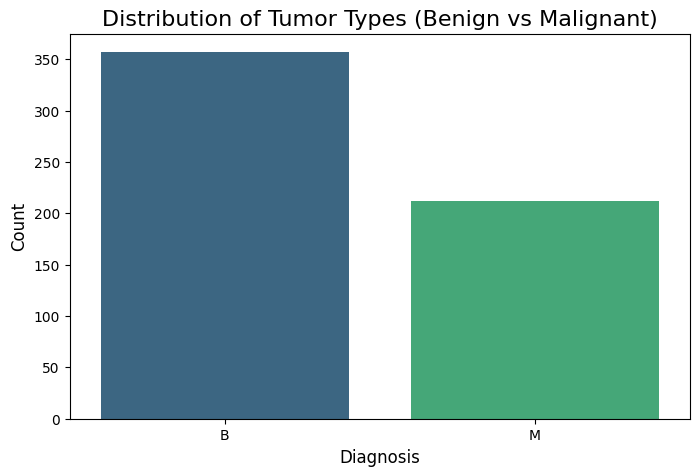

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(data=cancer, x='Diagnosis', palette='viridis')
plt.title('Distribution of Tumor Types (Benign vs Malignant)', fontsize=16)
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

We can see how the dataset is not completely balanced but rather over skewed towards Benign diagnosis rather than malignancies.

We now present some feature distributions by Diagnosis. The features that we will consider will include physical aspects of the different cancers diagnosed.

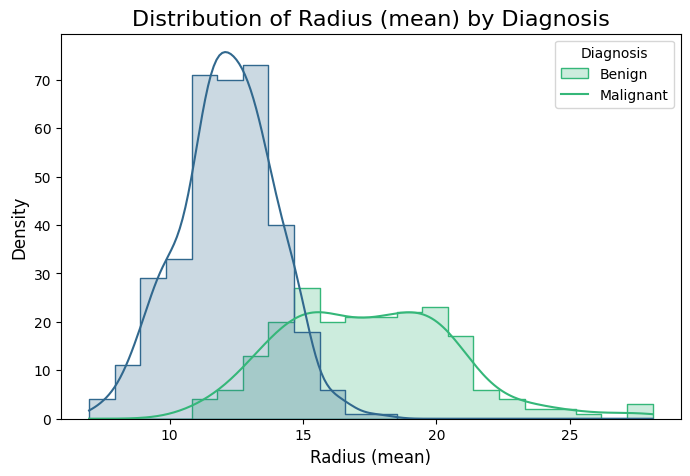

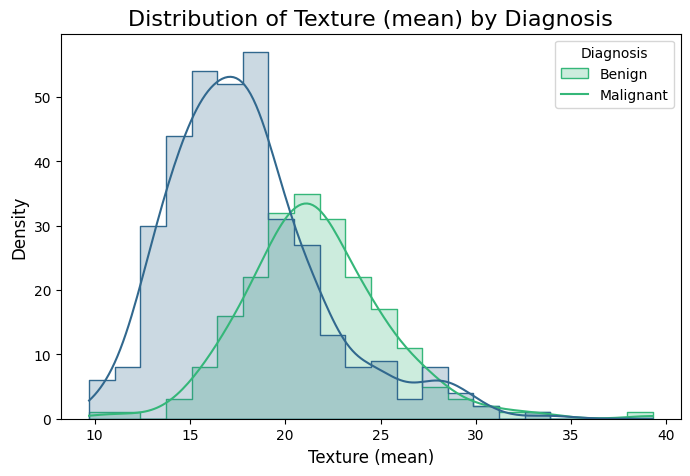

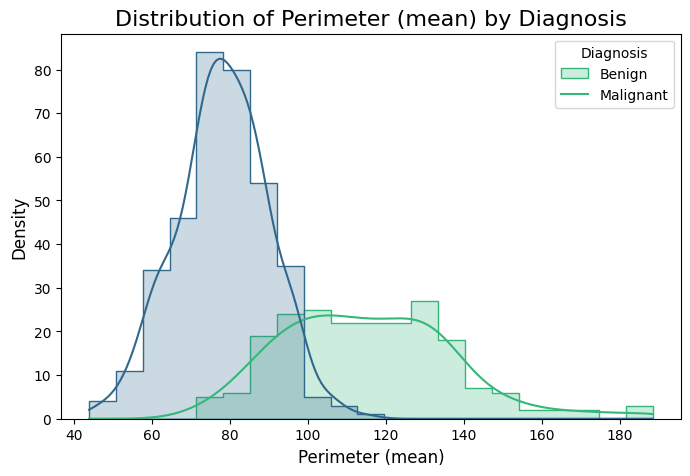

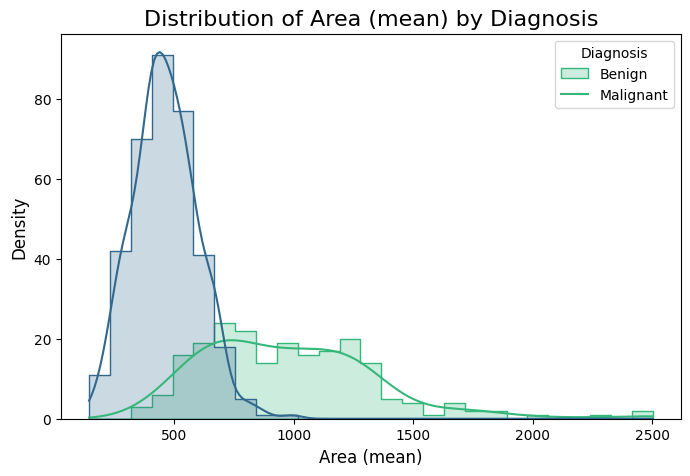

In [6]:
key_features = ['Radius (mean)', 'Texture (mean)', 'Perimeter (mean)', 'Area (mean)']

for feature in key_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=cancer, x=feature, hue='Diagnosis', kde=True, palette='viridis', element='step')
    plt.title(f'Distribution of {feature} by Diagnosis', fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
    plt.show()

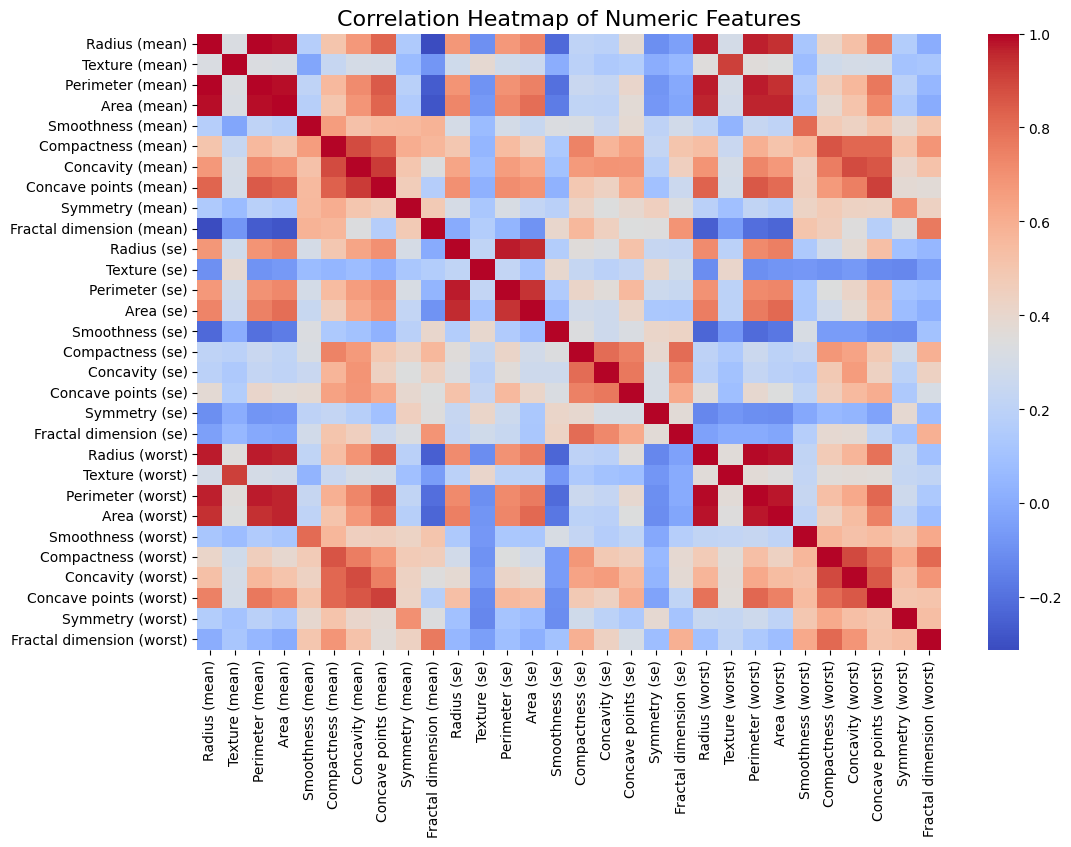

In [7]:
plt.figure(figsize=(12, 8))
correlation_matrix = cancer.iloc[:, 2:].corr()  # Exclude non-numeric columns
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar=True)
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()

## Feature Importance Analysis

We try to find the top 10 feature to consider in further analysis.

/var/folders/nb/j1cpyxn54656lsvpdckh21w80000gn/T/ipykernel_71984/69251235.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='t-statistic', y='Feature', palette='viridis')


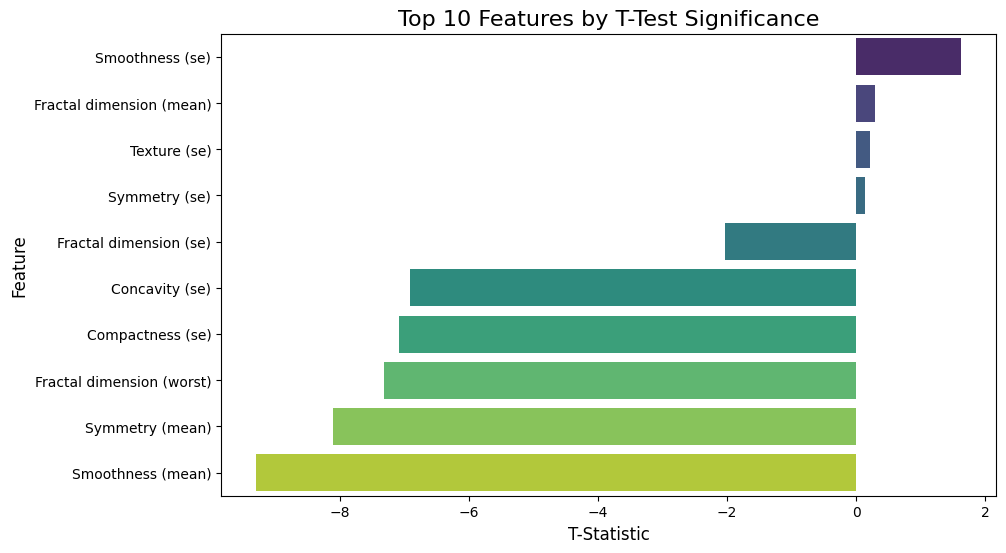

In [8]:
# Separate the data by Diagnosis
benign = cancer[cancer['Diagnosis'] == 'B']
malignant = cancer[cancer['Diagnosis'] == 'M']

# Perform t-tests for all numeric features to assess importance
feature_columns = cancer.columns[2:]  # Exclude non-numeric columns
ttest_results = {
    'Feature': [],
    't-statistic': [],
    'p-value': []
}

for feature in feature_columns:
    t_stat, p_value = ttest_ind(benign[feature], malignant[feature], equal_var=False)
    ttest_results['Feature'].append(feature)
    ttest_results['t-statistic'].append(t_stat)
    ttest_results['p-value'].append(p_value)

# Convert results to a DataFrame
ttest_df = pd.DataFrame(ttest_results)
ttest_df.sort_values(by='t-statistic', ascending=False, inplace=True)

# Visualize the top 10 most significant features
top_features = ttest_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='t-statistic', y='Feature', palette='viridis')
plt.title('Top 10 Features by T-Test Significance', fontsize=16)
plt.xlabel('T-Statistic', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

The data is in accordance with biological studies that show that malign tumors tend to be larger and more irregular than benign ones.

## Clustering and Dimensionality Reduction

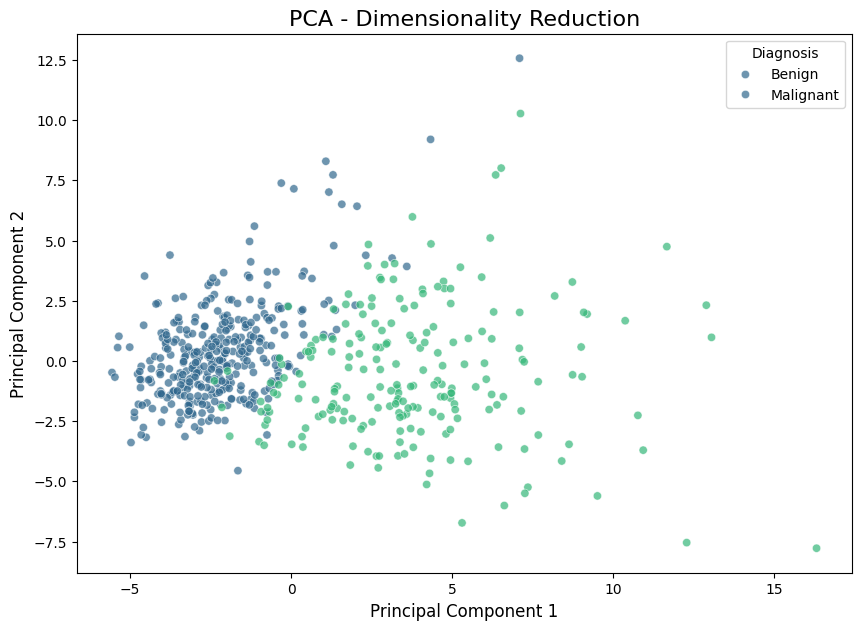

In [9]:
# Standardize the data
features = cancer.iloc[:, 2:]  # Exclude ID and Diagnosis columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
cancer['PCA1'] = pca_result[:, 0]
cancer['PCA2'] = pca_result[:, 1]

# Visualize PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=cancer,
    x='PCA1',
    y='PCA2',
    hue='Diagnosis',
    palette='viridis',
    alpha=0.7
)
plt.title('PCA - Dimensionality Reduction', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
plt.show()

/var/folders/nb/j1cpyxn54656lsvpdckh21w80000gn/T/ipykernel_71984/607993522.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='viridis')


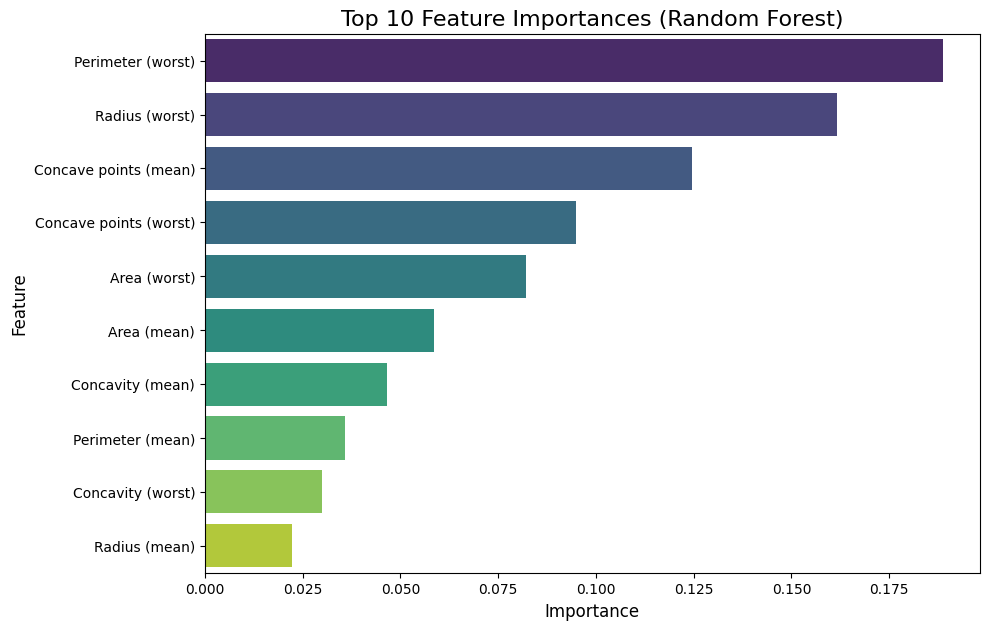

In [10]:
# Train a simple Random Forest model to compute feature importance
X = cancer.iloc[:, 2:-3]  # Exclude ID, Diagnosis, and PCA columns
y = cancer['Diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 7))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


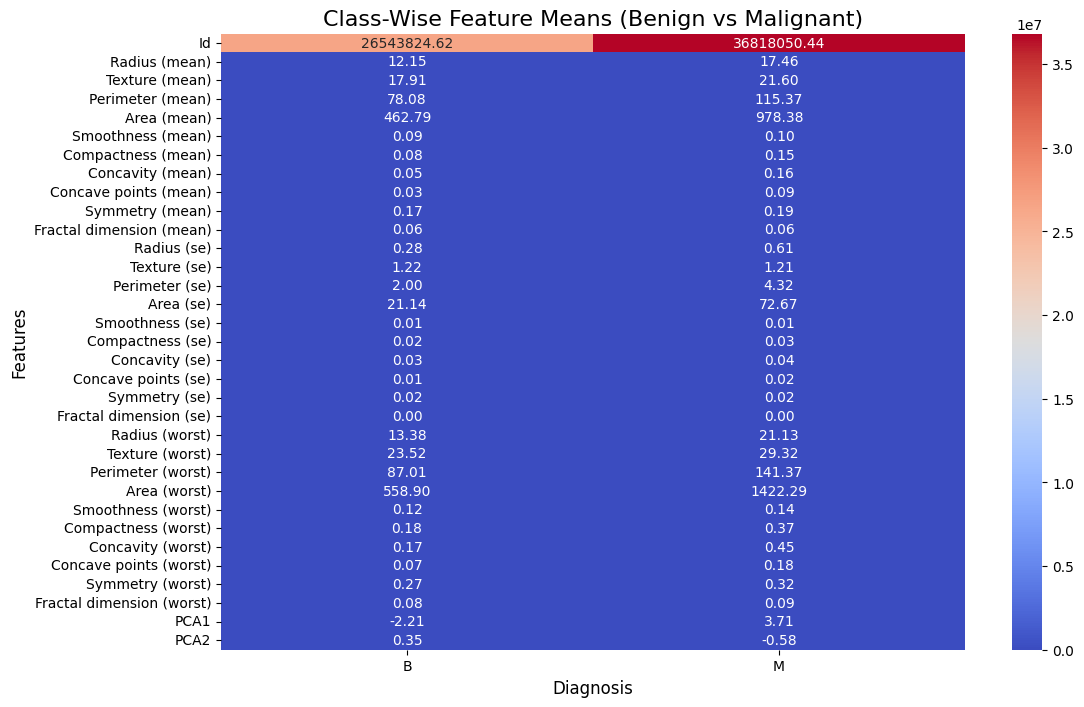

In [14]:
# Calculate class-wise feature means
class_means = cancer.groupby('Diagnosis').mean()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(class_means.T, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Class-Wise Feature Means (Benign vs Malignant)', fontsize=16)
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()


<Figure size 800x600 with 0 Axes>

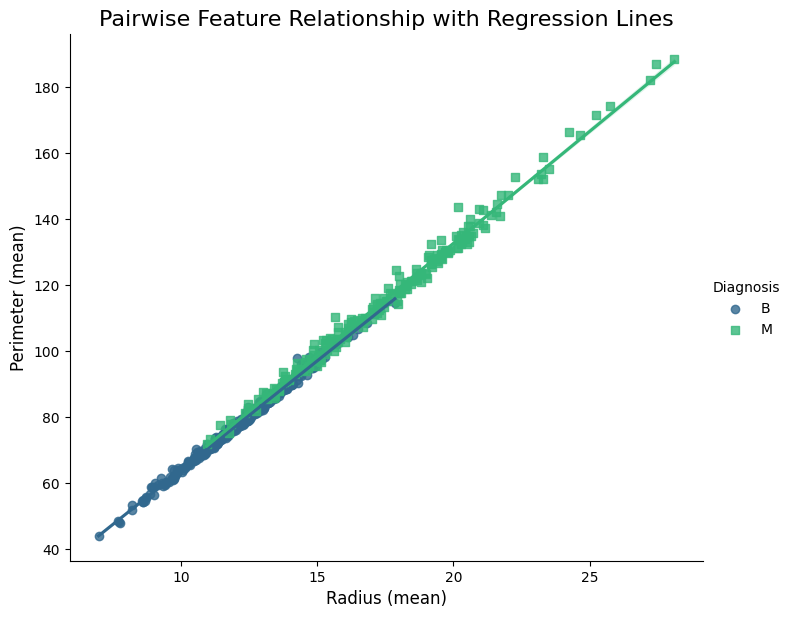

In [16]:
# Scatter plot for two features with regression lines
plt.figure(figsize=(8, 6))
sns.lmplot(
    data=cancer,
    x='Radius (mean)',
    y='Perimeter (mean)',
    hue='Diagnosis',
    palette='viridis',
    markers=['o', 's'],
    height=6,
    aspect=1.2
)
plt.title('Pairwise Feature Relationship with Regression Lines', fontsize=16)
plt.xlabel('Radius (mean)', fontsize=12)
plt.ylabel('Perimeter (mean)', fontsize=12)
plt.show()


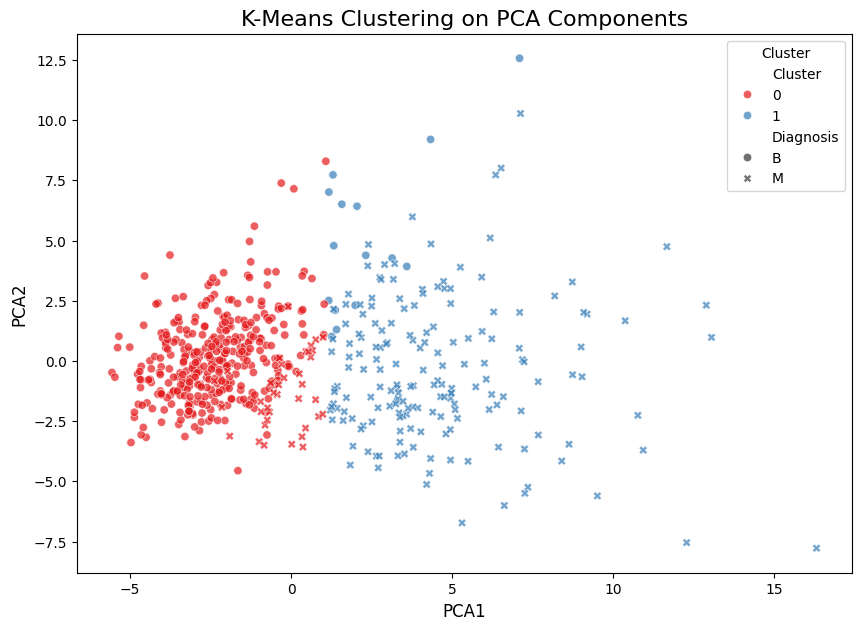

In [17]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cancer['Cluster'] = kmeans.fit_predict(cancer[['PCA1', 'PCA2']])

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=cancer,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='Set1',
    alpha=0.7,
    style=cancer['Diagnosis']
)
plt.title('K-Means Clustering on PCA Components', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Cluster')
plt.show()


## Classification Model: Random Forest

In [24]:
# Select all features except the ID and Diagnosis-related columns
X = cancer.iloc[:, 2:-3]  # Exclude ID, Diagnosis, and PCA columns
y = cancer['Diagnosis'].apply(lambda x: 1 if x == 'M' else 0)  # Encode target

# Train a Random Forest model to compute feature importance
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X, y)

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top features for model training
top_features = feature_importances.head(10)['Feature'].values
X_top = cancer[top_features]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest model with cross-validation
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Train the model on the full training set
rf_model.fit(X_train, y_train)

# Test set predictions
y_pred = rf_model.predict(X_test)

# Evaluate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())
print("\nTest Set Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Cross-Validation Scores: [0.96703297 0.98901099 0.91208791 0.95604396 0.9010989 ]
Mean Cross-Validation Accuracy: 0.945054945054945

Test Set Accuracy: 0.956140350877193

Confusion Matrix:
 [[72  0]
 [ 5 37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



The Random Forest model demonstrates excellent performance in classifying benign and malignant tumors, achieving a mean cross-validation accuracy of 94.5% and a test set accuracy of 95.6%. The confusion matrix highlights strong predictive ability, with 72 benign cases and 37 malignant cases correctly classified, though 5 malignant cases were misclassified as benign. The precision for benign tumors is 94%, and for malignant tumors, it is 100%, indicating no benign cases were wrongly classified as malignant. However, the recall for malignant tumors is slightly lower at 88%, meaning some malignant cases were missed. The F1-scores are 0.97 for benign and 0.94 for malignant, showing a balanced performance across both classes. These results suggest the model is highly reliable, but minor adjustments, such as optimizing the classification threshold, could further improve recall for malignant cases, which is critical in medical diagnostics.

## Favoring Malignant Predictions

In [25]:
# Get the prediction probabilities instead of class predictions
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class (malignant)

# Adjust threshold to favor malignant predictions (lower the threshold from 0.5)
new_threshold = 0.4
y_pred_adjusted = np.where(y_pred_prob >= new_threshold, 1, 0)

# Evaluate the adjusted predictions
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
class_report_adjusted = classification_report(y_test, y_pred_adjusted)

# Print adjusted results
print(f"Accuracy after adjusting threshold: {accuracy_adjusted}")
print("\nConfusion Matrix after adjusting threshold:")
print(conf_matrix_adjusted)
print("\nClassification Report after adjusting threshold:")
print(class_report_adjusted)

Accuracy after adjusting threshold: 0.9385964912280702

Confusion Matrix after adjusting threshold:
[[68  4]
 [ 3 39]]

Classification Report after adjusting threshold:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        72
           1       0.91      0.93      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



Adjusting the classification threshold to favor malignant predictions (lowering it to 0.4) improved the recall for malignant cases from 88% to 93%, reducing the number of missed malignant cases. However, this adjustment introduced 4 false positives, lowering the precision for benign predictions from 100% to 96%. The overall test set accuracy remains high at 93.9%, with balanced performance across both classes. This trade-off is critical in medical diagnostics, as increasing recall for malignant cases reduces the likelihood of missing potentially harmful conditions.